# Cài đặt các thư viện cần thiết

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10,6

#  Read file Web Trafic

In [2]:
raw_df = pd.read_csv('traffic.csv')
raw_df.head()

,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0


In [3]:
raw_df.tail()

,Date,Visits
1911,NaN,NaN
1912,NaN,NaN
1913,NaN,NaN
1914,NaN,NaN
1915,NaN,NaN


# Delete Mising Value and Outlier

In [4]:
raw_df['Date'].duplicated().sum()

1683

In [5]:
raw_df['Date'].isnull().sum()

1684

In [6]:
raw_df['Visits'].isnull().sum()

1684

In [7]:
notNull_df = raw_df.dropna()
notNull_df


,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0
...,...,...
227,8/15/2020,2221.0
228,8/16/2020,2724.0
229,8/17/2020,3456.0
230,8/18/2020,3581.0


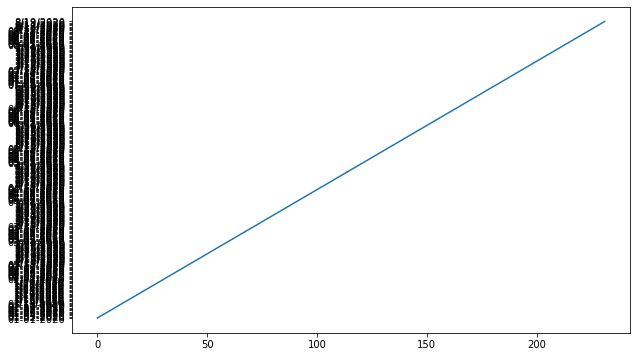

In [8]:
plt.plot(notNull_df['Date'])

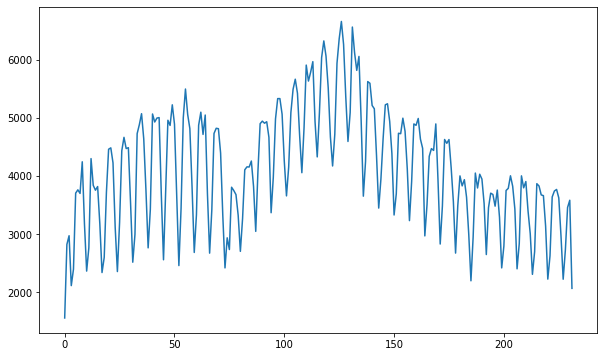

In [9]:
plt.plot(notNull_df['Visits'])

In [10]:
notNull_df['Date'] = pd.to_datetime(raw_df['Date'], infer_datetime_format=True)
indexed_df = notNull_df.set_index(['Date'])

C:\Users\HP\AppData\Local\Temp\ipykernel_1992\3922207586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  notNull_df['Date'] = pd.to_datetime(raw_df['Date'], infer_datetime_format=True)


In [11]:
from datetime import datetime
indexed_df.head()

,Visits
Date,
2020-01-01,1554.0
2020-01-02,2820.0
2020-01-03,2970.0
2020-01-04,2111.0
2020-01-05,2393.0


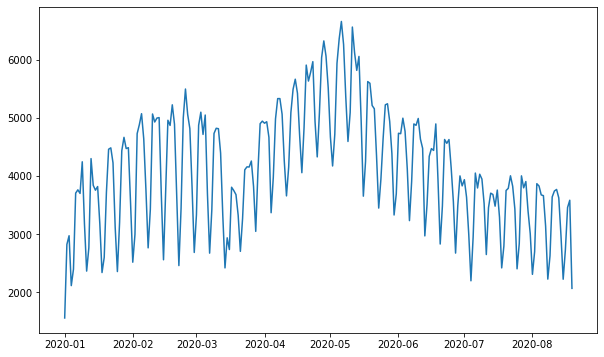

In [12]:
plt.plot(indexed_df)

# Normalization

,Visits
Date,
2020-08-15,2221.0
2020-08-16,2724.0
2020-08-17,3456.0
2020-08-18,3581.0
2020-08-19,2064.0


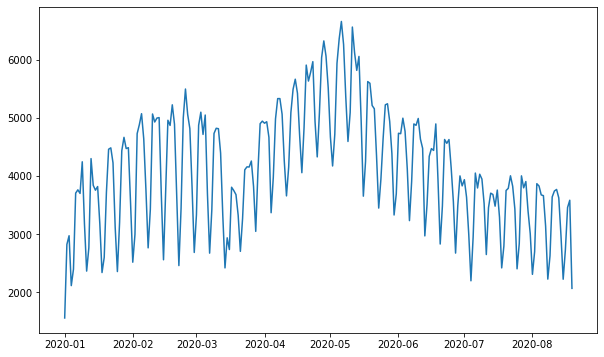

In [13]:
nor_df = indexed_df
plt.plot(nor_df)
nor_df.tail()

# Split into Train set and Test set

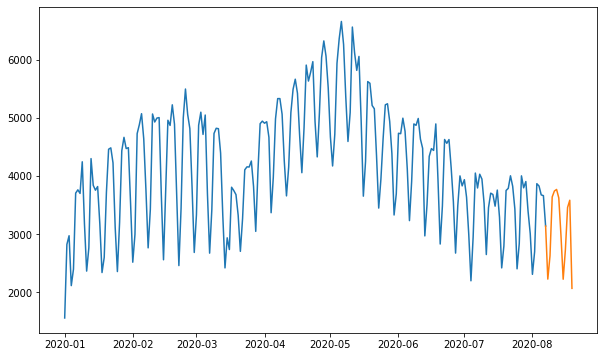

In [14]:
df_train = nor_df[:220].copy()
df_test = nor_df[219:].copy()
plt.plot(df_train)
plt.plot(df_test)

# Stationary

In [15]:
# Dickey Fuller Test

def perform_ad_fuller(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print("p-value: %f" % result[1])

perform_ad_fuller(df_train)

ADF Statistic: -1.667121
p-value: 0.448127


In [116]:
diff = df_train.diff(1).dropna()
perform_ad_fuller(diff)

ADF Statistic: -3.419567
p-value: 0.010310


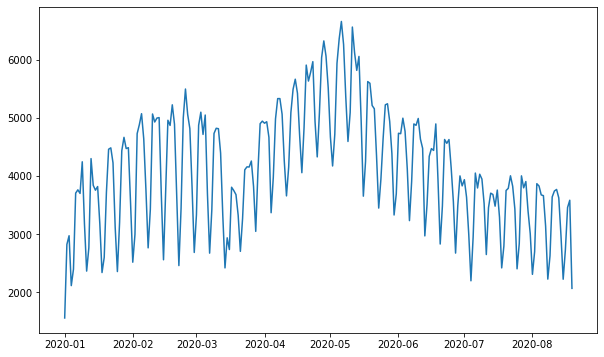

In [65]:
plt.plot(nor_df)

# Chose Model

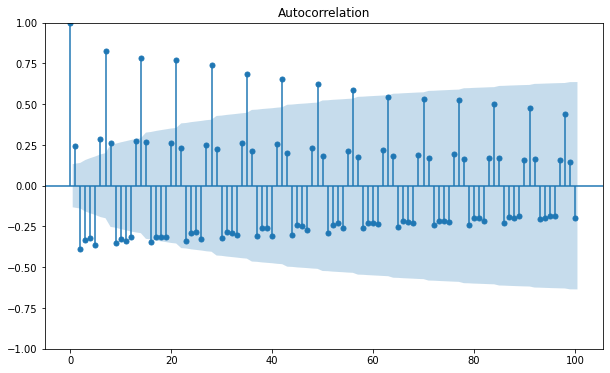

In [66]:
acf_plot = plot_acf(diff,lags=100)

C:\Users\HP\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


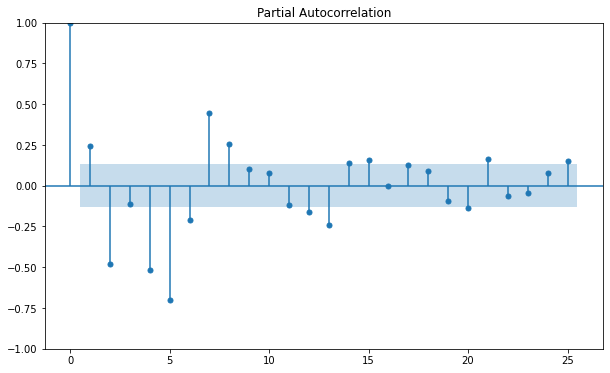

In [117]:
pacf_plot = plot_pacf(diff,lags=25)

Dua tren PACF, nen bat dau voi AR voi lags 1,2,4,5,7

In [127]:
from statsmodels.tsa.arima.model import ARIMA

# 7,1,0 ARIMA Model

model = ARIMA(df_train, order=(7,1,0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Visits   No. Observations:                  220
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -1586.203
Date:                Wed, 19 Apr 2023   AIC                           3188.405
Time:                        16:43:45   BIC                           3215.518
Sample:                    01-01-2020   HQIC                          3199.355
                         - 08-07-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1523      0.051     -2.979      0.003      -0.253      -0.052
ar.L2         -0.3826      0.055     -6.969      0.000      -0.490      -0.275
ar.L3         -0.2839      0.060     -4.711      0.0

In [126]:
def _arima_fit(orders, data):
    models = dict()
    for order in orders:
        model = ARIMA(data,order = order).fit()
        model_name = 'ARIMA({},{},{})'.format(order[0],order[1],order[2])
        print('{} -> AIC={}; BIC={}'.format(model_name,model.aic,model.bic))
        models[model_name] = model
    return models
orders = [(7,1,0),(7,2,0),(5,1,0),(5,2,0),(4,1,0),(4,2,0),(2,1,0),(2,2,0),(1,1,0),(1,2,0)]
models = _arima_fit(orders,df_train)

ARIMA(7,1,0) -> AIC=3188.4051969214183; BIC=3215.5177707599505
ARIMA(7,2,0) -> AIC=3186.042633656589; BIC=3213.1185941589015
ARIMA(5,1,0) -> AIC=3236.423759745341; BIC=3256.75819012424
ARIMA(5,2,0) -> AIC=3373.0794593138453; BIC=3393.38642969058
ARIMA(4,1,0) -> AIC=3375.7682750529075; BIC=3392.71363370199
ARIMA(4,2,0) -> AIC=3517.625083607072; BIC=3534.5475589210178
ARIMA(2,1,0) -> AIC=3437.272292052273; BIC=3447.4395072417224
ARIMA(2,2,0) -> AIC=3527.4165262900697; BIC=3537.5700114784368
ARIMA(1,1,0) -> AIC=3491.9827085885686; BIC=3498.7608520482017
ARIMA(1,2,0) -> AIC=3578.0754678390076; BIC=3584.8444579645857


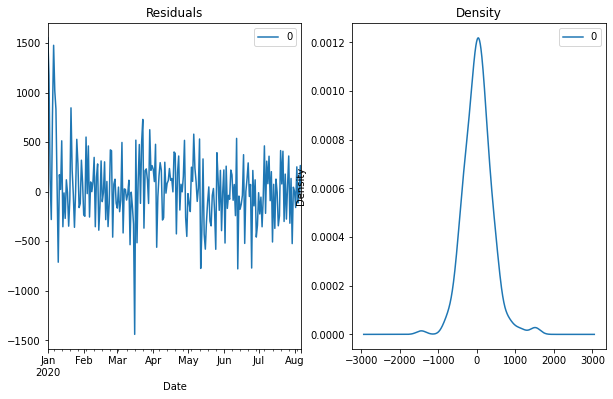

2020-08-07    3188.499415
2020-08-08    2445.359300
2020-08-09    2875.394444
2020-08-10    3804.014126
2020-08-11    3816.410541
2020-08-12    3649.653474
2020-08-13    3635.708687
2020-08-14    3135.719038
2020-08-15    2535.044059
2020-08-16    2961.848423
2020-08-17    3745.744797
2020-08-18    3774.799784
2020-08-19    3625.078937
Freq: D, Name: predicted_mean, dtype: float64

In [128]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

predictions = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
predictions

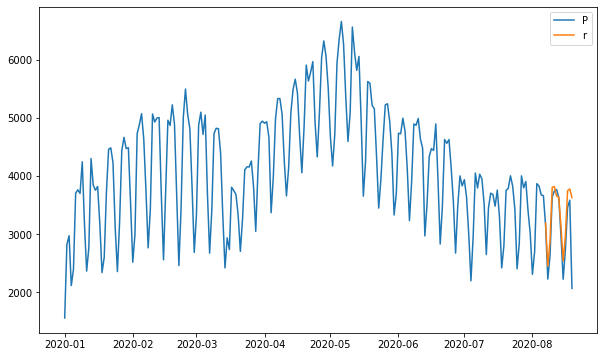

In [129]:
plt.plot(nor_df)
plt.plot(predictions)
plt.legend("Actual")
plt.legend("Predict")
plt.show()

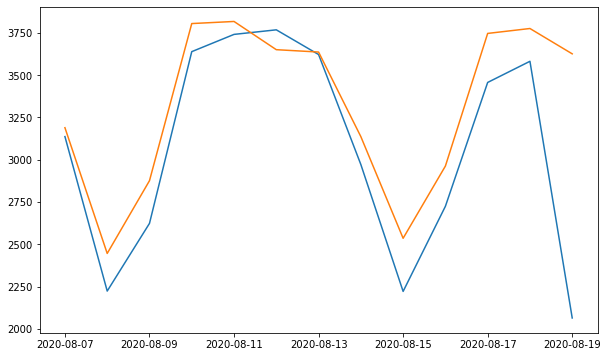

In [130]:
plt.plot(df_test)
plt.plot(predictions)

In [131]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
mse = mean_squared_error(df_test,predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test,predictions)
mape = mean_absolute_percentage_error(df_test,predictions)
print("MSE :{}\
      RMSE :{}\
      MAE :{}\
      MAPE :{}".format(mse,rmse,mae,mape))


MSE :223391.87459778812      RMSE :472.64349630327945      MAE :281.7667749983961      MAPE :0.11482445321104323
